In [1]:
# import libraries
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import pytorch_lightning as pl
import torch.utils.data as data

In [2]:
# check the environment
print("Current working directory: ", os.getcwd())
print("OS name: ", sys.platform)
print("Python executable: ", sys.executable)
print("Python version: ", sys.version)
print("PyTorch version: ", torch.__version__)
print("PyTorch Lightning version: ", pl.__version__)
print("CUDA version: ", torch.version.cuda)
print("cuDNN version: ", torch.backends.cudnn.version())
print("Number of GPUs: ", torch.cuda.device_count())
print("GPU model: ", torch.cuda.get_device_name(0))

Current working directory:  /gpfs02/work/akira.tokiwa/gpgpu/Github/SR3D/tests
OS name:  linux
Python executable:  /gpfs02/work/akira.tokiwa/gpgpu/anaconda3/envs/pylit/bin/python
Python version:  3.10.9 (main, Jan 11 2023, 15:21:40) [GCC 11.2.0]
PyTorch version:  2.0.1+cu117
PyTorch Lightning version:  1.9.3
CUDA version:  11.7
cuDNN version:  8500
Number of GPUs:  1
GPU model:  NVIDIA GeForce RTX 2080 Ti


In [3]:
# import modules
sys.path.append('../')
from scripts.dataloader.data import get_loaders_from_params, get_data_from_params, get_normalized_from_params, get_loaders, Transforms
from scripts.models.Unet_base import Unet
from scripts.diffusion.ddpm import DDPM
from scripts.diffusion.scheduler import TimestepSampler
from scripts.utils.run_utils import setup_trainer, get_parser
from scripts.params import set_params

In [4]:
pl.seed_everything(1234)

[rank: 0] Global seed set to 1234


1234

In [5]:
params = set_params(n_maps=10,use_attn=True,batch_size=4)

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [7]:
lr, hr = get_data_from_params(params)
lr = lr.unsqueeze(1)
hr = hr.unsqueeze(1)
log2linear_transform = Transforms("log2linear", None, None)
lr, hr = log2linear_transform.inverse_transform(lr), log2linear_transform.inverse_transform(hr)

LR data loaded from /gpfs02/work/tanimura/ana/UNet/data/dens_magneticum_snap25_Box128_grid32_CIC_noRSD/.  Number of maps: 10
HR data loaded from /gpfs02/work/tanimura/ana/UNet/data/dens_magneticum_snap25_Box128_grid64_CIC_noRSD/.  Number of maps: 10


In [8]:
lr.shape

torch.Size([10, 1, 32, 32, 32])

In [9]:
data_input, data_cond, transforms_input, transforms_cond = get_normalized_from_params(lr, hr, params)
train_loader, val_loader = get_loaders(data_input, data_cond, params["train"]['train_rate'], params["train"]['batch_size'])
print("train:validation = {}:{}, batch_size: {}".format(len(train_loader), len(val_loader), params["train"]['batch_size']))

LR data normalized to [0.7814010381698608,0.9868751168251038] by sigmoid transform.
HR data normalized to [0.5889384150505066,0.9841253757476807] by sigmoid transform.
train:validation = 2:1, batch_size: 4


In [10]:
#get sampler type
sampler = TimestepSampler(
timesteps=int(params['diffusion']['timesteps']), 
sampler_type=params['diffusion']['sampler_type'])
print("sampler type: {}, timesteps: {}".format(params['diffusion']['sampler_type'], params['diffusion']['timesteps']))

#get model
model = DDPM(Unet, params, sampler = sampler)


Sampler type uniform


sampler type: uniform, timesteps: 2000
We are using Adam with lr = 0.0001, gamma = 0.9999
The schedule is linear with beta_start = 1e-06, beta_end = 0.01


In [21]:
data_input = data_input.to(device)
data_cond = data_cond.to(device)

In [24]:
t = model.sampler.get_timesteps(data_input.shape[0], 0).to(device)
print(t.shape)

torch.Size([10])


In [25]:
model.model(data_input, t, condition=data_cond)

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [11]:
trainer = setup_trainer(params)
trainer.fit(model, train_loader, val_loader)

data saved in /gpfs02/work/akira.tokiwa/gpgpu/Github/SR3D/ckpt_logs/diffusion/
data name: HR_sigmoid_linear_concat_b4


/gpfs02/work/akira.tokiwa/gpgpu/anaconda3/envs/pylit/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /gpfs02/work/akira.tokiwa/gpgpu/anaconda3/envs/pylit ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/gpfs02/work/akira.tokiwa/gpgpu/anaconda3/envs/pylit/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /gpfs02/work/akira.tokiwa/gpgpu/anaconda3/envs/pylit ...
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_D

Epoch 0:   0%|          | 0/3 [00:00<?, ?it/s] 

RuntimeError: Given groups=1, weight of size [128, 64, 1, 1, 1], expected input[4, 128, 32, 32, 32] to have 64 channels, but got 128 channels instead

# Generate map

In [12]:
ckpt_log = save_dir + "/SR3D_diffusion/version_5/checkpoints/last.ckpt"
sd = torch.load(ckpt_log)["state_dict"]
model.load_state_dict(sd)
model.eval()
model.freeze()

In [13]:
tmp_diffusion = model.diffusion

In [14]:
import matplotlib.pyplot as plt
import numpy as np

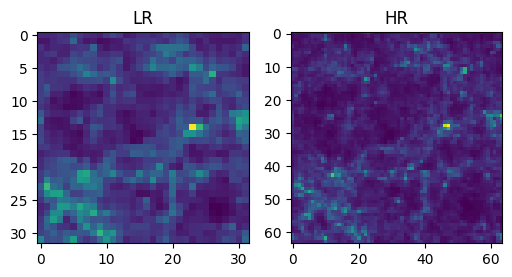

In [15]:
# project the data to 2D
lr_proj = combined_dataset.tensors[1][0].cpu().numpy()
lr_proj = lr_proj.squeeze(0)
lr_proj = np.sum(lr_proj, axis=0)

hr_proj = combined_dataset.tensors[0][0].cpu().numpy()
hr_proj = hr_proj.squeeze(0)
hr_proj = np.sum(hr_proj, axis=0)

fig, ax = plt.subplots(1,2, figsize=(6,3))
ax[0].imshow(lr_proj)
ax[0].set_title("LR")
ax[1].imshow(hr_proj)
ax[1].set_title("HR")
plt.show()

In [16]:
map_dir = save_dir + "/../generated"
if not os.path.exists(map_dir):
        os.makedirs(map_dir)

In [17]:
print("Start Diffusion")
tmp_hr = combined_dataset.tensors[0][0].unsqueeze(0).to(device)
tmp_lr = combined_dataset.tensors[1][0].unsqueeze(0).to(device)
tmp_upsample_lr = nn.Upsample(scale_factor = 2, mode='trilinear')(tmp_lr)
tmp_sample = tmp_hr - tmp_upsample_lr
q_sample = tmp_diffusion.q_sample(tmp_sample, torch.full((1,), timesteps-1, device=device))
img = torch.randn(tmp_sample.shape, device=device)

Start Diffusion


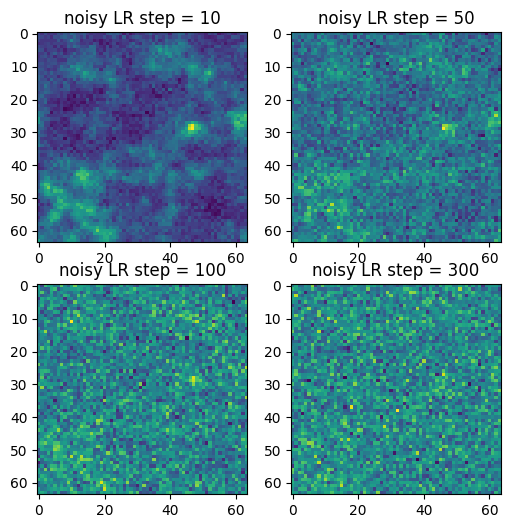

In [18]:
# plot diffused maps
fig, ax = plt.subplots(2,2, figsize=(6,6))
tmp = tmp_diffusion.q_sample(tmp_sample, torch.full((1,), 10-1, device=device))+tmp_upsample_lr 
ax[0,0].imshow((tmp+tmp_upsample_lr).squeeze(0).squeeze(0).cpu().numpy().sum(axis=0))
ax[0,0].set_title("noisy LR step = 10")

tmp = tmp_diffusion.q_sample(tmp_sample, torch.full((1,), 50-1, device=device))+tmp_upsample_lr
ax[0,1].imshow((tmp+tmp_upsample_lr).squeeze(0).squeeze(0).cpu().numpy().sum(axis=0))
ax[0,1].set_title("noisy LR step = 50")

tmp = tmp_diffusion.q_sample(tmp_sample, torch.full((1,), 100-1, device=device))+tmp_upsample_lr
ax[1,0].imshow((tmp+tmp_upsample_lr).squeeze(0).squeeze(0).cpu().numpy().sum(axis=0))
ax[1,0].set_title("noisy LR step = 100")

tmp = tmp_diffusion.q_sample(tmp_sample, torch.full((1,), 300-1, device=device))+tmp_upsample_lr
ax[1,1].imshow((tmp+tmp_upsample_lr).squeeze(0).squeeze(0).cpu().numpy().sum(axis=0))
ax[1,1].set_title("noisy LR step = 300")
plt.show()

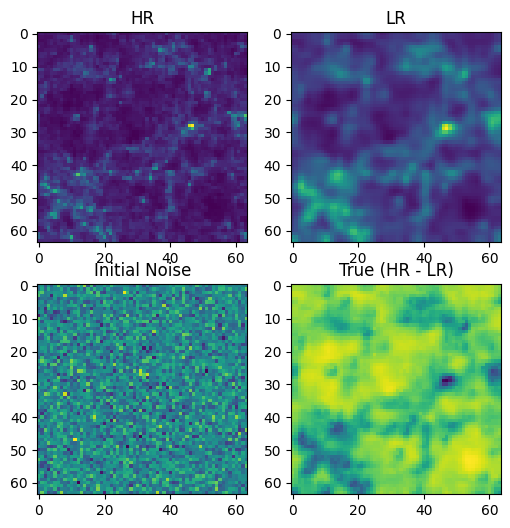

In [19]:
# plot initial image
fig, ax = plt.subplots(2,2, figsize=(6,6))
ax[0,0].imshow(tmp_hr.squeeze(0).squeeze(0).cpu().numpy().sum(axis=0))
ax[0,0].set_title("HR")
ax[0,1].imshow(tmp_upsample_lr.squeeze(0).squeeze(0).cpu().numpy().sum(axis=0))
ax[0,1].set_title("LR")
ax[1,0].imshow(img.squeeze(0).squeeze(0).cpu().numpy().sum(axis=0))
ax[1,0].set_title("Initial Noise")
ax[1,1].imshow(tmp_sample.squeeze(0).squeeze(0).cpu().numpy().sum(axis=0))
ax[1,1].set_title("True (HR - LR)")
plt.show()

In [20]:
print(img.min().detach().cpu().numpy(), img.max().detach().cpu().numpy())
print(tmp_sample.min().detach().cpu().numpy(), tmp_sample.max().detach().cpu().numpy())

-4.9156485 4.369962
-0.6837623 0.23722827


In [21]:
from tqdm import tqdm

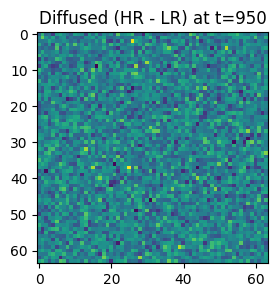

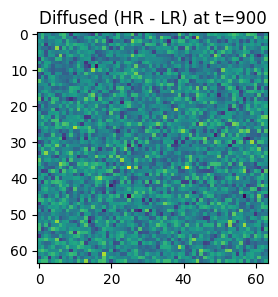

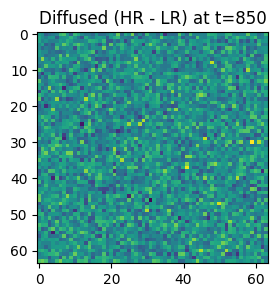

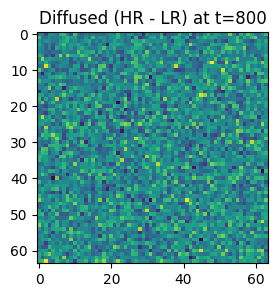

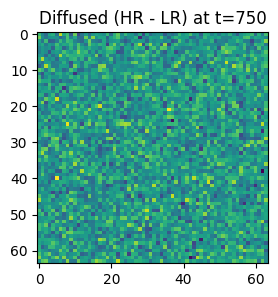

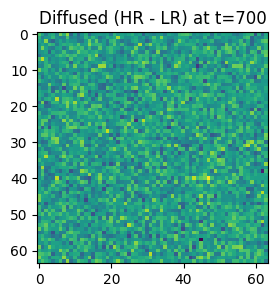

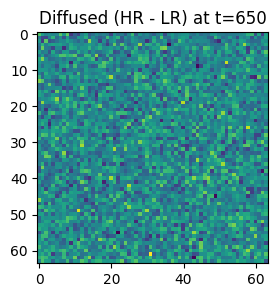

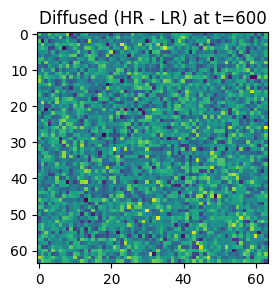

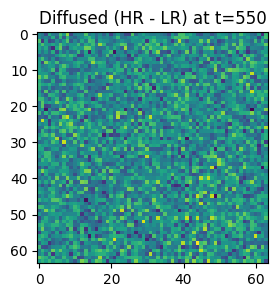

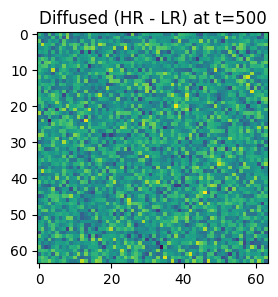

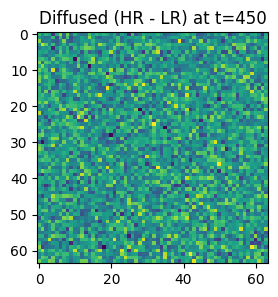

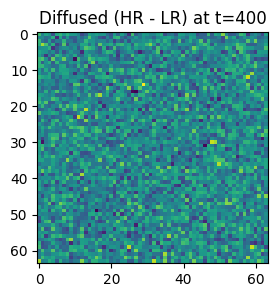

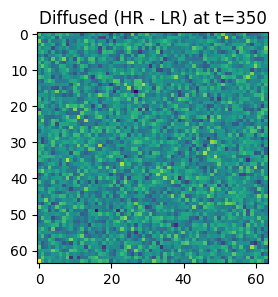

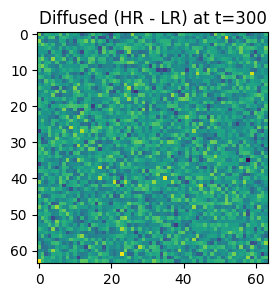

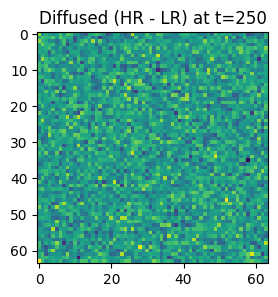

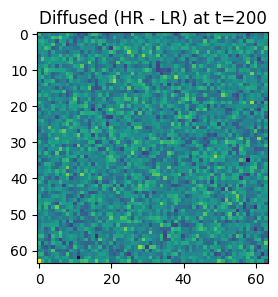

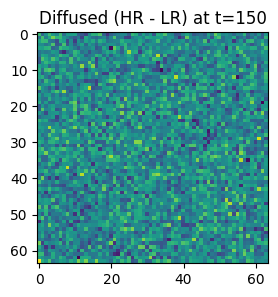

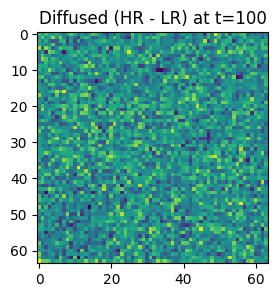

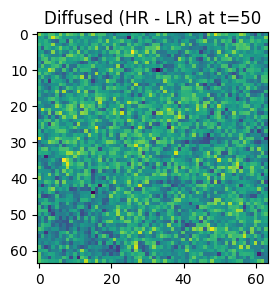

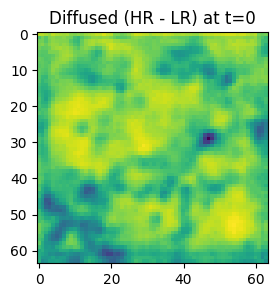

In [22]:
model.eval()
model.freeze()
imgs = []
for j in reversed(range(0, timesteps)):
    t = torch.full((1,), j, device=device, dtype=torch.long)
    loss = tmp_diffusion.p_losses(model.model, tmp_sample, t, labels=tmp_upsample_lr)
    img = tmp_diffusion.p_sample(model.model, img, t, j, label=tmp_upsample_lr)
    #print('Step {}, Loss {}'.format(j, loss), flush=True)
    if (j % 50 == 0):
        diffmap = img.detach().cpu().numpy().squeeze(0).squeeze(0).sum(axis=0)
        imgs.append(diffmap)
        fig, ax = plt.subplots(1,1, figsize=(3,3))
        ax.imshow(diffmap)
        ax.set_title("Diffused (HR - LR) at t={}".format(j))
        plt.show()
        plt.close()

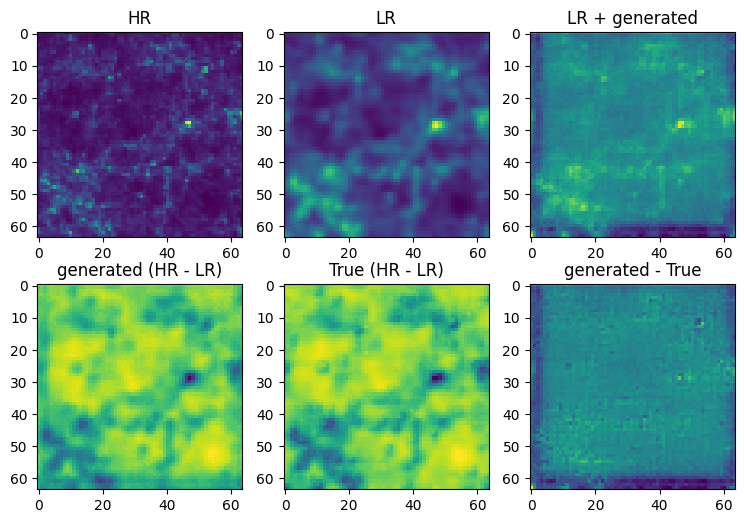

In [41]:
fig, ax = plt.subplots(2, 3, figsize=(9, 6))

images = [
    (tmp_hr, "HR"),
    (tmp_upsample_lr, "LR"),
    (img + tmp_upsample_lr, "LR + generated"),
    (img, "generated (HR - LR)"),
    (tmp_sample, "True (HR - LR)"),
    (img - tmp_sample, "generated - True")
]

for i, (image, title) in enumerate(images):
    row = i // 3
    col = i % 3
    ax[row, col].imshow(image.squeeze(0).squeeze(0).cpu().numpy().sum(axis=0))
    ax[row, col].set_title(title)

plt.show()

In [56]:
random_idx = np.random.randint(0, 64, 5)

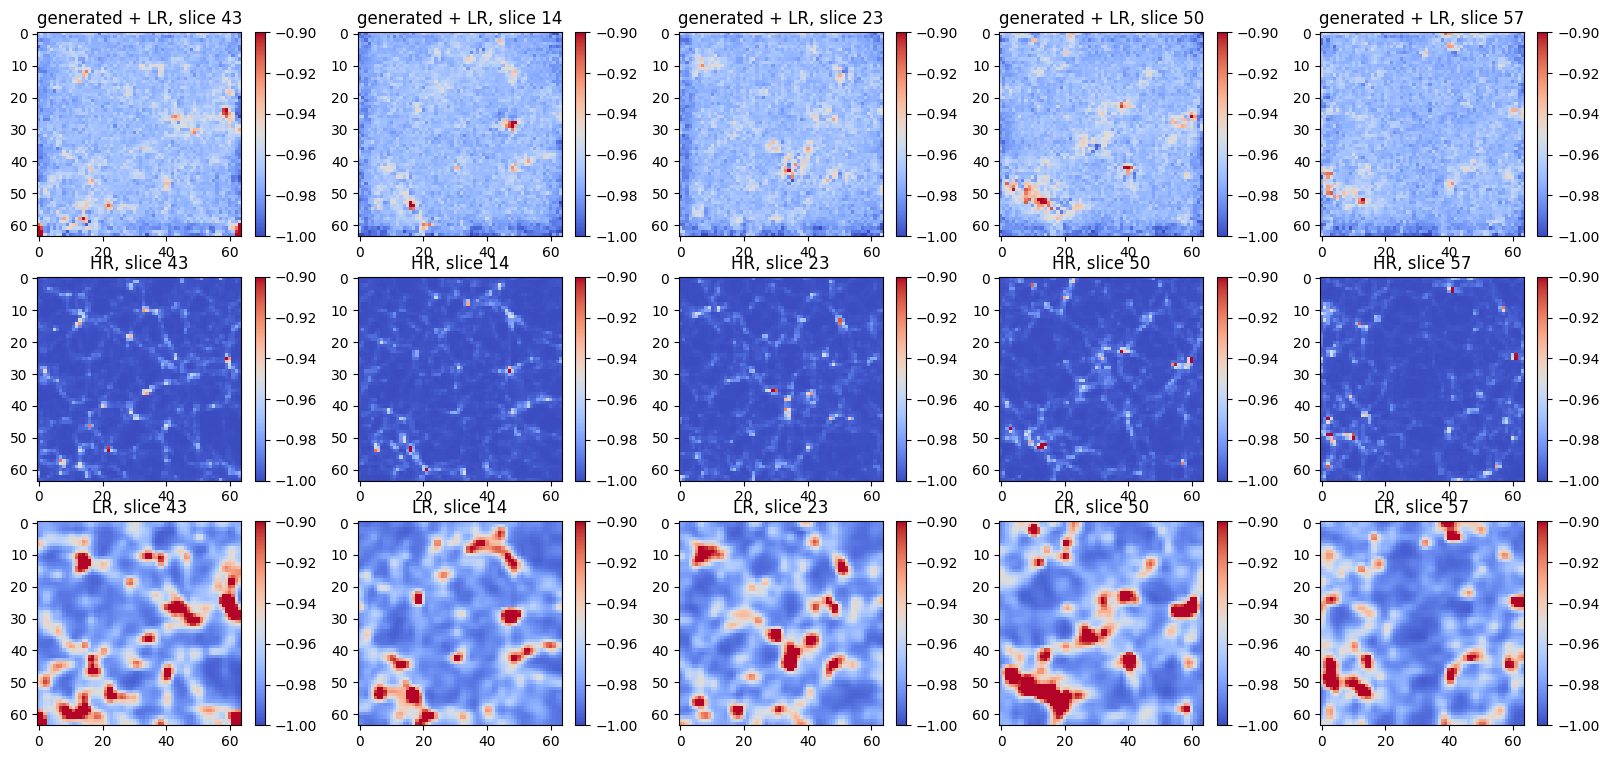

In [66]:
fig, ax = plt.subplots(3,5, figsize=(20,9))
for i in range(5):
    # plot with colorbar
    im = ax[0,i].imshow((img + tmp_upsample_lr).squeeze(0).squeeze(0).cpu().numpy()[random_idx[i]], vmin=-1, vmax=-0.9, cmap='coolwarm')
    ax[0,i].set_title("generated + LR, slice {}".format(random_idx[i]))
    fig.colorbar(im, ax=ax[0,i])
    
    im = ax[1,i].imshow((tmp_hr).squeeze(0).squeeze(0).cpu().numpy()[random_idx[i]], vmin=-1, vmax=-0.9, cmap='coolwarm')
    ax[1,i].set_title("HR, slice {}".format(random_idx[i]))
    fig.colorbar(im, ax=ax[1,i])

    im = ax[2,i].imshow((tmp_upsample_lr).squeeze(0).squeeze(0).cpu().numpy()[random_idx[i]], vmin=-1, vmax=-0.9, cmap='coolwarm')
    ax[2,i].set_title("LR, slice {}".format(random_idx[i]))
    fig.colorbar(im, ax=ax[2,i])
plt.show()